In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from scipy.spatial.distance import cosine

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from scipy import stats
import itertools

Import the embeddings

In [5]:
dataset = "CelebA"
metadata = pd.read_parquet(f"../../data/embeddings/{dataset}/df_generated.parquet")
metadata = metadata.reset_index()

metadata2 = pd.read_parquet(f"../../data/embeddings/{dataset}/df_dataset.parquet")

MODEL_NAMES = ["retina_facenet","retina_arcface"]
MODEL_METRICS = ["euclidean", "cosine"]

embeddings = {}
for m, model_name in enumerate(MODEL_NAMES):
    data_npz = np.load(f"../../data/embeddings/{dataset}/embeddings_{model_name}_generated.npz")
    embeddings[model_name] = data_npz['a']

Load point clouds

In [6]:
ids = {}
for f in metadata["file_basename"].unique():
    ids[f] = metadata2.loc[metadata2["file_basename"] == f]["identity"].item()
np.unique(np.array(list(ids.values())))

array([ 305, 2202, 2762, 2996, 3962, 4978, 5078, 5903, 9689, 9797])

In [7]:
def get_point_cloud_id(metadata,ids,identity,model_name):
    df2 = metadata.loc[(metadata["feature"] == "head_hair_color")
                   & (metadata["curve"] == 0)]

    files_to_identity = [k for k in ids.keys() if ids[k]==identity]

    indices_identity = [df2.loc[(df2["param_step"]==2) 
            & (df2["file_basename"] == f)].index.item() 
            for f in files_to_identity]

    X = embeddings[model_name][indices_identity,:]
    return X, indices_identity,files_to_identity

def generate_sc(X,tau = 0.3, eps = 0.02):
      D = distance_matrix(X,X)
      #A = np.exp(-D**2/tau)
      A = D*(D<eps)
      A *= A>10**-10
      #A *= A>eps
      #A = A - np.diag(np.diag(A))
      G = nx.from_numpy_array(A)
      triangles = [c for c in nx.enumerate_all_cliques(G) if len(c) == 3]
      return G,triangles

def generate_sc_knn(X,k = 10, metric = "cosine"):
      A = kneighbors_graph(X,k, mode = "distance", metric = metric)
      G = nx.from_numpy_array(A)
      triangles = [c for c in nx.enumerate_all_cliques(G) if len(c) == 3]
      return G,triangles

def plot_sc(G, pos = None, vf = None):
      f,ax = plt.subplots(1,1,figsize = (5,4))
      __,weights = zip(*nx.get_edge_attributes(G,'weight').items())
      nx.draw(G,width = [0.4*1/w for w in weights], ax = ax, pos = pos, node_size = 10, node_color = 'k', alpha = 0.8)
      if vf is not None and pos is not None:
            ax.quiver(*pos.T, *vf.T, color = "tab:red", width = 0.005)
      ax.set_title("Simplicial complex $\Delta$")
      if pos is not None:
            ax.set_xlim([np.min(pos[:,0])-0.1,np.max(pos[:,0])+0.1])
            ax.set_ylim([np.min(pos[:,1])-0.1,np.max(pos[:,1])+0.1])

def compute_hodge_laplacian(G,triangles):
      n0 = len(G.nodes)
      n1 = len(G.edges)
      n2 = len(triangles)
      B1 = np.zeros((n0,n1))
      for e in range(n1):
            nodes = list(G.edges)[e]
            B1[nodes[0], e] = -1
            B1[nodes[1], e] = 1


      edge_dict = {}
      for i, edge in enumerate(list(G.edges)):
            # Create a tuple to represent the edge (order doesn't matter)
            edge_key = tuple(sorted(edge))
            # Store the edge index in the dictionary
            edge_dict[edge_key] = i


      W1 = np.zeros(n1)
      for e in range(n1):
            ed = list(G.edges)[e]
            W1[edge_dict[ed]] = G.get_edge_data(ed[0],ed[1])["weight"]

      #W1 = 1/W1

      B2 = np.zeros((n1,n2))

      for face_idx, face in enumerate(triangles):
            # Iterate over the three edges of the face
            for i in range(3):
                  # Determine the start and end nodes of the edge
                  edge = np.array(face)[np.arange(3) != i]

                  # Find the corresponding edge index in the edges list
                  edge_idx = edge_dict[tuple(sorted(edge))]
                  # Set the appropriate entry in `boundary_2`
                  B2[edge_idx, face_idx] = (-1) ** i



      #W2 = (B2.T@W1)**2

      W2 = np.zeros(n2)
      
      for face_idx,t in enumerate(triangles):
            ed1 = (t[0],t[1])
            ed2 = (t[0],t[2])
            ed3 = (t[1],t[2])
            led1 = W1[edge_dict[ed1]]
            led2 = W1[edge_dict[ed2]]
            led3 = W1[edge_dict[ed3]]
            s = (led1 + led2 + led3)/2
            #W2[face_idx] = s
            area = np.sqrt(s*(s-led1)*(s-led2)*(s-led3))
            if np.isnan(area):
                  area = np.inf
            W2[face_idx] = area

      #W2 = 1/W2

      L1 = B1.T@B1@np.diag(1/W1) + np.diag(W1)@B2@np.diag(1/W2)@B2.T
      
      return L1,W1,W2,edge_dict

def vf_to_cochain(vf, pos, edge_dict):
    # PDP flat
    c = np.zeros(len(edge_dict.keys()))
    for ed in list(edge_dict.keys()):
        v1 = vf[ed[0],:]
        v2 = vf[ed[1],:]
        dir = pos[ed[1],:] - pos[ed[0],:]

        dir /= np.linalg.norm(dir)

        c[edge_dict[ed]] = (v1@dir + v2@dir)/2

    return c


def compute_energy(X,vf,L1,W1,edge_dict, normalize = True, return_norm = False):
      c = vf_to_cochain(vf, X, edge_dict)

      norm_c = (c.T@np.diag(1/W1)@c)
      if normalize:
            c /= norm_c
      energy = c.T@np.diag(1/W1)@L1@c/len(c)
      if return_norm:
            return energy, norm_c
      else:
            return energy
def compute_energy_easy(vf,W1,edge_dict):
      en = 0
      for i,e in enumerate(edge_dict.keys()):
            en += 1/W1[i]*np.sum((vf[e[1],:]-vf[e[0],:])**2)
      return en

def compute_energy_easy_cos(vf,W1,edge_dict):
      en = 0
      for i,e in enumerate(edge_dict.keys()):
            en += 1/W1[i]*cosine(vf[e[1],:],vf[e[0],:])
      en /= np.sum(1/W1)
      return en



In [8]:
def run_simulation(simulation_params):

  # Args
  sc_type = simulation_params["sc_type"]
  energy_type = simulation_params["energy_type"]
  n_rep = simulation_params["null_model_repetitions"]
  NORMALIZE = simulation_params["normalize"]
  eps = simulation_params["eps"]
  k = simulation_params["k"]

  features = metadata["feature"].unique()
  identities = np.unique(list(ids.values()))

  energy_m = {}
  variance_direction_m = {}
  norm_cs_m = {}
  null_m = {}


  for m,model in enumerate(MODEL_NAMES):
    print(f"Model: {model}")
    energy = []
    variance_direction = []
    norm_cs = []
    null = []

    for identity in tqdm(identities):
      # Build simplicial complex
      X, indices_identity, files_to_identity = get_point_cloud_id(metadata,ids,identity, model)
      
      if sc_type == "VR":
        G,triangles = generate_sc(X,eps = eps)
      elif sc_type == "knn":
        G,triangles = generate_sc_knn(X,k = k, metric = MODEL_METRICS[m])
      else:
        return False
      
      n1 = len(G.edges)

      L1,W1,W2,edge_dict = compute_hodge_laplacian(G,triangles)
      
      df0 = metadata[metadata['file_basename'].isin(files_to_identity)]
      energy.append([])
      variance_direction.append([])
      norm_cs.append([])
      null.append([])
      cov_matrix = np.cov((X-np.mean(X,0)).T)

      for n in range(n_rep):
        vf = np.random.rand(X.shape[0],X.shape[1])*2 - 1
        vf = (vf.T/np.linalg.norm(vf,axis = 1)).T
        en,nc = compute_energy(X,vf,L1,W1,edge_dict, normalize = NORMALIZE, return_norm = True)
        null[-1].append(en)

      for feature in features:
        energy[-1].append([])
        variance_direction[-1].append([])
        norm_cs[-1].append([])
        df1 = df0.loc[(df0["feature"] == feature)]

        for curve in metadata.loc[metadata["feature"] == feature]["curve"].unique():
          df2 = df1.loc[(df1["curve"] == curve)]


          vf_indices = np.array([list(df2.loc[df2["param_step"] == 0].index),
                                 list(df2.loc[df2["param_step"] == 1].index),
                                 list(df2.loc[df2["param_step"] == 3].index),
                                 list(df2.loc[df2["param_step"] == 4].index)]).T 
          
          vf = [-embeddings[model_name][vf_indices[i,3],:] 
                +8*embeddings[model_name][vf_indices[i,2],:] 
                -8*embeddings[model_name][vf_indices[i,1],:] 
                +embeddings[model_name][vf_indices[i,0],:] 
                for i in range(len(vf_indices))]
          
          vf = np.array(vf)
          vf = (vf.T/np.linalg.norm(vf,axis = 1)).T

          if energy_type == "hodge":
            en,nc = compute_energy(X,vf,L1,W1,edge_dict, normalize = NORMALIZE, return_norm = True)
          elif energy_type == "naive":
            en = compute_energy_easy(vf,W1,edge_dict)
            if NORMALIZE:
              en /= n1
            nc = 0
          elif energy_type == "naive_cos":
            en = compute_energy_easy_cos(vf,W1,edge_dict)
            nc = 0

          mean_vf = np.mean(vf,0)
          mean_vf /= np.linalg.norm(mean_vf)

          variance_direction[-1][-1].append(1/(mean_vf.T@cov_matrix@mean_vf))
          energy[-1][-1].append(en)
          norm_cs[-1][-1].append(nc)

    energy_m[model] = energy
    variance_direction_m[model] = variance_direction
    norm_cs_m[model] = norm_cs
    null_m[model] = null

  return {"energy": energy_m, "variance": variance_direction_m, "norms": norm_cs_m, "null": null_m}
  

def plot_results(results):
  features = metadata["feature"].unique()
  fig, ax = plt.subplots(2,3,figsize = (13,8))
  for m, model in enumerate(MODEL_NAMES):
      agg_energy = np.array([[np.mean(e) for e in i] for i in results["energy"][model]])
      agg_var = np.array([[np.mean(e) for e in i] for i in results["variance"][model]])
      agg_normc = np.array([[np.mean(e) for e in i] for i in results["norms"][model]])

      ax[m,0].set_ylabel('Dirichlét energy')
      bplot = ax[m,0].boxplot(agg_energy,
                      patch_artist=True,  # fill with color
                      )    

      ax[m,0].set_title("Dirichlét energy")

      ax[m,2].set_ylabel('Inverse variance in direction')
      bplot = ax[m,2].boxplot(agg_var,
                      patch_artist=True,  # fill with color
                      )    
      
      ax[m,2].set_title("Inverse covariance in mean direction")

      ax[m,1].set_ylabel('Norm')
      bplot = ax[m,1].boxplot(agg_normc,
                      patch_artist=True,  # fill with color
                      )    

      ax[m,1].set_title("Norm of c")
      if m == 1:
          for i in range(3):
              ax[m,i].set_xticklabels(features, rotation = 90);

  plt.show()


In [9]:
def run_simulation_all(simulation_params):

  # Args
  n_rep = simulation_params["null_model_repetitions"]

  features = metadata["feature"].unique()
  identities = np.unique(list(ids.values()))

  energy_m = {}
  variance_direction_m = {}
  null_m = {}


  for m,model in enumerate(MODEL_NAMES):
    print(f"Model: {model}")
    energy = []
    variance_direction = []
    norm_cs = []
    null = []

    for identity in tqdm(identities):
      # Build simplicial complex
        X, indices_identity, files_to_identity = get_point_cloud_id(metadata,ids,identity, model)  

        if MODEL_METRICS[m] == "euclidean":
            D_mat = euclidean_distances(X,X)
        elif MODEL_METRICS[m] == "cosine":
            D_mat = cosine_distances(X,X)

        inv_D_mat = np.nan_to_num(1/D_mat, posinf = 0)
        normalization = np.nansum(inv_D_mat)

      
        df0 = metadata[metadata['file_basename'].isin(files_to_identity)]
        energy.append([])
        variance_direction.append([])
        norm_cs.append([])
        null.append([])
        cov_matrix = np.cov((X-np.mean(X,0)).T)

        for n in range(n_rep):
            vf = np.random.rand(X.shape[0],X.shape[1])*2 - 1
            vf = (vf.T/np.linalg.norm(vf,axis = 1)).T
            D_mat_vf = cosine_distances(vf)
            en = np.sum(D_mat_vf*inv_D_mat)/normalization
            null[-1].append(en)

        for feature in features:
          energy[-1].append([])
          variance_direction[-1].append([])
          norm_cs[-1].append([])
          df1 = df0.loc[(df0["feature"] == feature)]

          for curve in metadata.loc[metadata["feature"] == feature]["curve"].unique():
            df2 = df1.loc[(df1["curve"] == curve)]


            vf_indices = np.array([list(df2.loc[df2["param_step"] == 0].index),
                                  list(df2.loc[df2["param_step"] == 1].index),
                                  list(df2.loc[df2["param_step"] == 3].index),
                                  list(df2.loc[df2["param_step"] == 4].index)]).T 
            
            vf = [-embeddings[model_name][vf_indices[i,3],:] 
                  +8*embeddings[model_name][vf_indices[i,2],:] 
                  -8*embeddings[model_name][vf_indices[i,1],:] 
                  +embeddings[model_name][vf_indices[i,0],:] 
                  for i in range(len(vf_indices))]
            
            vf = np.array(vf)
            vf = (vf.T/np.linalg.norm(vf,axis = 1)).T
            D_mat_vf = cosine_distances(vf)
            en = np.sum(D_mat_vf*inv_D_mat)/normalization

            mean_vf = np.mean(vf,0)
            mean_vf /= np.linalg.norm(mean_vf)

            variance_direction[-1][-1].append(1/(mean_vf.T@cov_matrix@mean_vf))
            energy[-1][-1].append(en)

    energy_m[model] = energy
    variance_direction_m[model] = variance_direction
    null_m[model] = null

  return {"energy": energy_m, "variance": variance_direction_m,"null": null_m}
    


## KNN, Hodge, Normalized

In [8]:
features = metadata["feature"].unique()

Model: retina_facenet


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]


Model: retina_arcface


100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


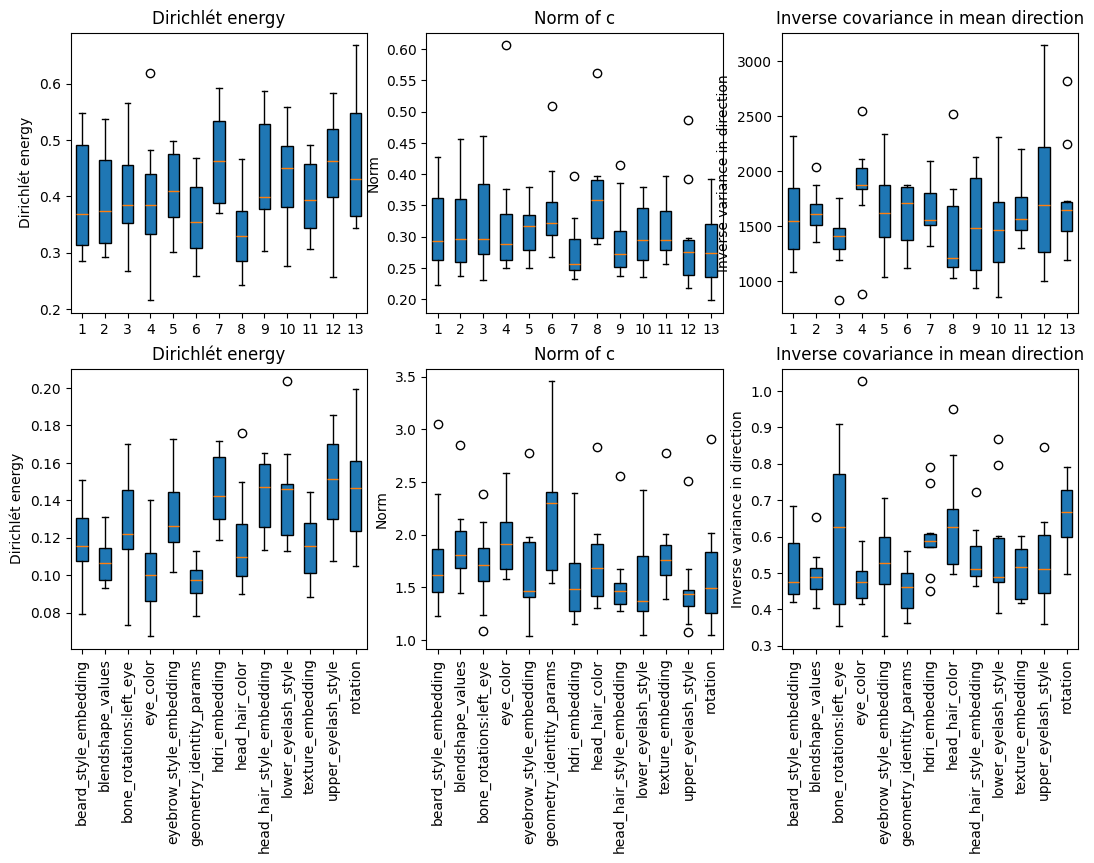

In [9]:
k = 10
NORMALIZE = True
n_rep = 100

sc_type = "knn" # "VR"
energy_type = "hodge" # "naive"

simulation_params = {
  "sc_type": sc_type,
  "energy_type": energy_type,
  "null_model_repetitions": n_rep,
  "normalize": NORMALIZE,
  "eps" : 0.2,
  "k" : k
}

results_dict = run_simulation(simulation_params)

plot_results(results_dict)

Text(0, 0.5, 'Energy')

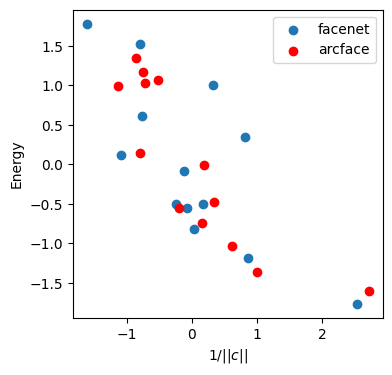

In [48]:
agg_energy_0 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["energy"][MODEL_NAMES[0]]]),axis = 0)
agg_normc_0 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["norms"][MODEL_NAMES[0]]]), axis = 0)

agg_energy_1 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["energy"][MODEL_NAMES[1]]]), axis = 0)
agg_normc_1 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["norms"][MODEL_NAMES[1]]]), axis = 0)

plt.figure(figsize = (4,4))
plt.scatter((agg_normc_0 - np.mean(agg_normc_0))/np.std(agg_normc_0), (agg_energy_0 - np.mean(agg_energy_0))/np.std(agg_energy_0), label = "facenet")
plt.scatter((agg_normc_1 - np.mean(agg_normc_1))/np.std(agg_normc_1), (agg_energy_1 - np.mean(agg_energy_1))/np.std(agg_energy_1), color  = "red", label = "arcface")
plt.legend()
plt.xlabel("$1/||c||$")
plt.ylabel("Energy")

The correlation between energy and the norm of c is too high to think that this measure is actually capturing smoothness. The Dirichlet energy is capturing more the "representability" of the vector field on the cochain space.  

## KNN, Hodge, NOT Normalized

Model: retina_facenet


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


Model: retina_arcface


100%|██████████| 10/10 [00:24<00:00,  2.47s/it]


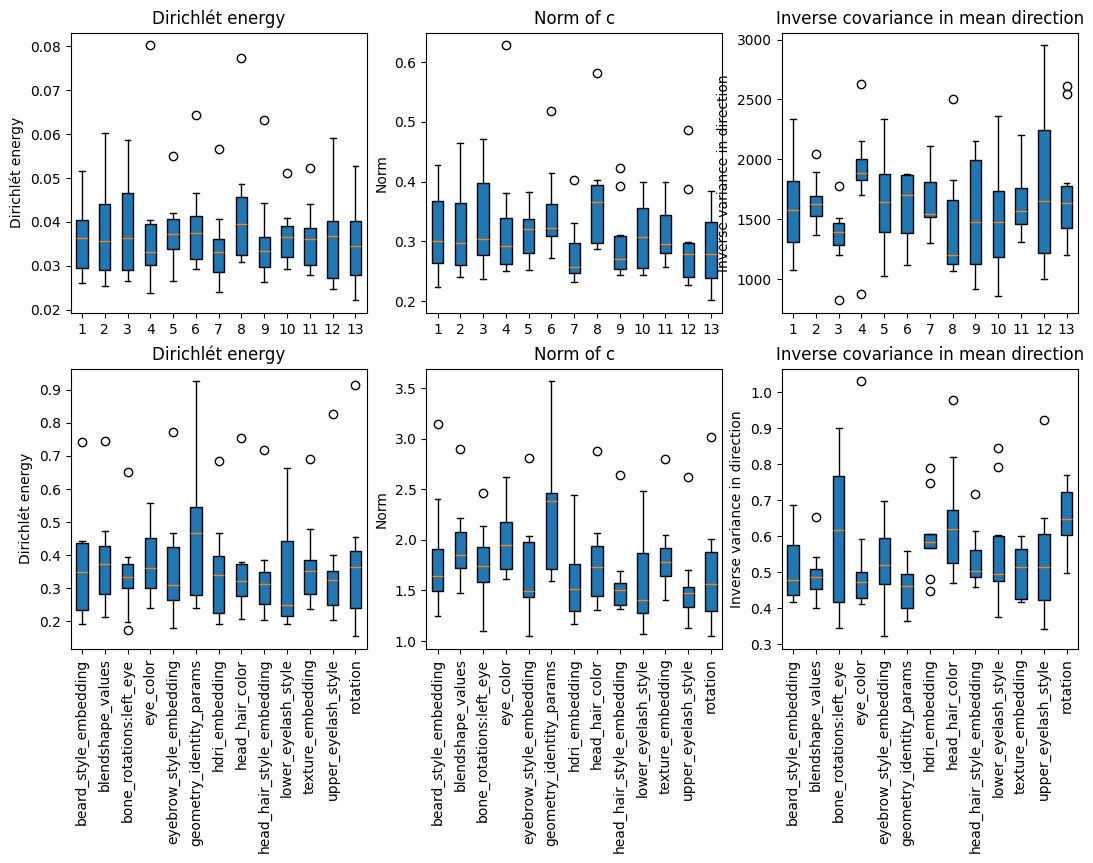

In [51]:
k = 10
NORMALIZE = False
n_rep = 1

sc_type = "knn" # "VR"
energy_type = "hodge" # "naive"

simulation_params = {
  "sc_type": sc_type,
  "energy_type": energy_type,
  "null_model_repetitions": n_rep,
  "normalize": NORMALIZE,
  "eps" : 0.2,
  "k" : k
}

results_dict = run_simulation(simulation_params)

plot_results(results_dict)

Text(0, 0.5, 'Energy')

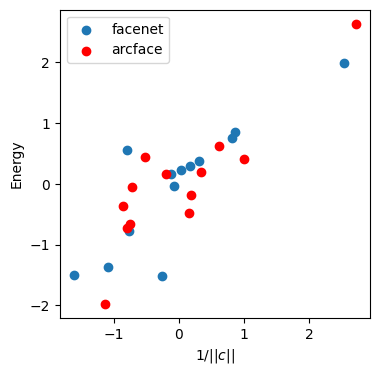

In [52]:
agg_energy_0 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["energy"][MODEL_NAMES[0]]]),axis = 0)
agg_normc_0 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["norms"][MODEL_NAMES[0]]]), axis = 0)

agg_energy_1 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["energy"][MODEL_NAMES[1]]]), axis = 0)
agg_normc_1 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["norms"][MODEL_NAMES[1]]]), axis = 0)

plt.figure(figsize = (4,4))
plt.scatter((agg_normc_0 - np.mean(agg_normc_0))/np.std(agg_normc_0), (agg_energy_0 - np.mean(agg_energy_0))/np.std(agg_energy_0), label = "facenet")
plt.scatter((agg_normc_1 - np.mean(agg_normc_1))/np.std(agg_normc_1), (agg_energy_1 - np.mean(agg_energy_1))/np.std(agg_energy_1), color  = "red", label = "arcface")
plt.legend()
plt.xlabel("$1/||c||$")
plt.ylabel("Energy")

## KNN, Naive, NON Normalized

The idea of the "naive" smoothness implementation is to measure the local distance between vectors, weighted by the edge weight.
$$
E(V) = \sum_{(i,j)\in\mathcal{E}} \frac{1}{d(x_i,x_j)} \lvert\lvert v_i - v_j \rvert \rvert^2
$$

## KNN, Naive, Normalized

Model: retina_facenet


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


Model: retina_arcface


100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


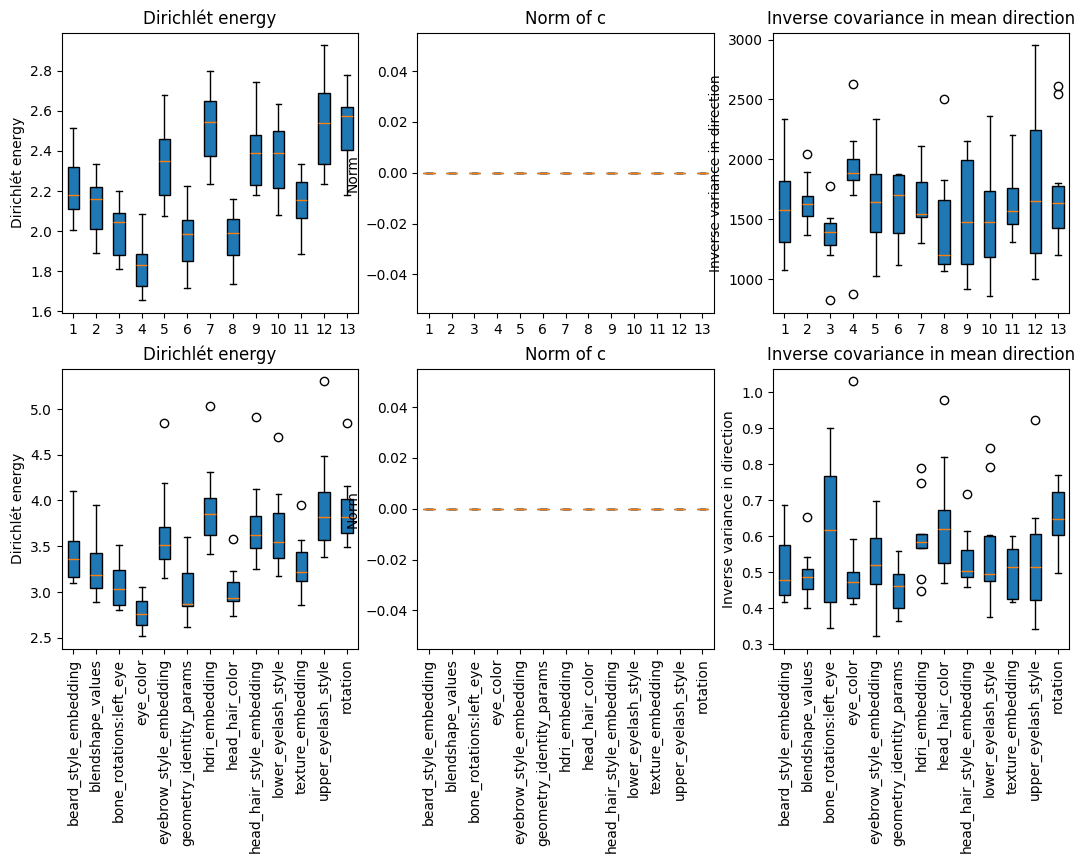

In [16]:
k = 10
NORMALIZE = True
n_rep = 100

sc_type = "knn" # "VR"
energy_type = "naive" # "naive"

simulation_params = {
  "sc_type": sc_type,
  "energy_type": energy_type,
  "null_model_repetitions": n_rep,
  "normalize": NORMALIZE,
  "eps" : 0.2,
  "k" : k
}

results_dict = run_simulation(simulation_params)

plot_results(results_dict)

Text(0, 0.5, 'Energy')

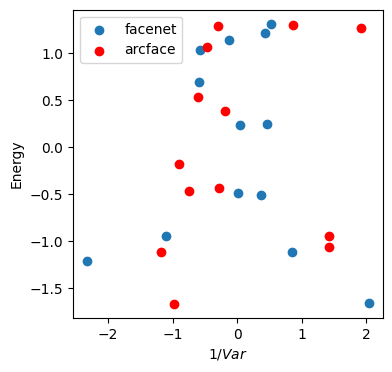

In [8]:
agg_energy_0 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["energy"][MODEL_NAMES[0]]]),axis = 0)
agg_normc_0 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["variance"][MODEL_NAMES[0]]]), axis = 0)

agg_energy_1 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["energy"][MODEL_NAMES[1]]]), axis = 0)
agg_normc_1 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["variance"][MODEL_NAMES[1]]]), axis = 0)

plt.figure(figsize = (4,4))
plt.scatter((agg_normc_0 - np.mean(agg_normc_0))/np.std(agg_normc_0), (agg_energy_0 - np.mean(agg_energy_0))/np.std(agg_energy_0), label = "facenet")
plt.scatter((agg_normc_1 - np.mean(agg_normc_1))/np.std(agg_normc_1), (agg_energy_1 - np.mean(agg_energy_1))/np.std(agg_energy_1), color  = "red", label = "arcface")
plt.legend()
plt.xlabel("$1/Var$")
plt.ylabel("Energy")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Arcface energy')

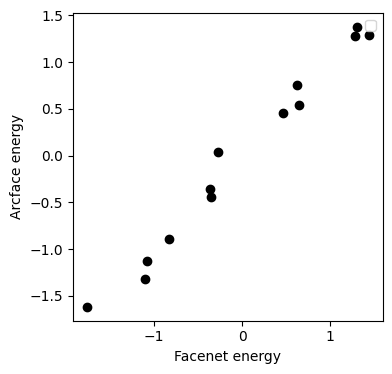

In [19]:
agg_energy_0 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["energy"][MODEL_NAMES[0]]]),axis = 0)
agg_energy_1 = np.median(np.array([[np.mean(e) for e in i] for i in results_dict["energy"][MODEL_NAMES[1]]]), axis = 0)


plt.figure(figsize = (4,4))
plt.scatter((agg_energy_0 - np.mean(agg_energy_0))/np.std(agg_energy_0), (agg_energy_1 - np.mean(agg_energy_1))/np.std(agg_energy_1), color  = "k")
plt.legend()
plt.xlabel("Facenet energy")
plt.ylabel("Arcface energy")

I think that this measure is actually more meaningful for our work. The Hodge-Dirichlet one would make more sense when we can assume that the identity point cloud is a good approximation of the "manifold" it is a sample of. However 30 points is really a small number and trying to extract too much geometry from it could be harmful. 

**Note:** Actually this last measure is the Dirichlét energy associated to the *Sheaf Laplacian* of the *constant sheaf* on the k-neighbors graph.
If we are interested in capturing more the geometry of the point cloud (which is made of too few points I think) we could build a non-constant sheaf on it: basically meaning adding into the edges the notion of curvature of the point cloud. This is done usually by performing local PCA on each point and aligning the local basis obtained. Once again, I think we have too few points for this.

## All-to-all, Naive Cosine

The idea of the "naive cosine" smoothness implementation is to measure the local cosine distance between vectors, weighted by the inverse edge weight.
$$
E(V) = \sum_{(i,j)\in\mathcal{E}} \frac{1}{d(x_i,x_j)} \left(1-\frac{v_i^\top v_j}{||v_i||||v_j||}\right)
$$
which is then normalized by $\sum_{(i,j)\in\mathcal{E}}\frac{1}{d(x_i,x_j)}$

In [10]:
n_rep = 10

simulation_params = {
  "null_model_repetitions": n_rep,
}

results_dict = run_simulation_all(simulation_params)

Model: retina_facenet


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_20098/3601108781.py:31: RuntimeWarning: divide by zero encountered in divide
  inv_D_mat = np.nan_to_num(1/D_mat, posinf = 0)
 10%|█         | 1/10 [00:01<00:12,  1.43s/it]/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_20098/3601108781.py:31: RuntimeWarning: divide by zero encountered in divide
  inv_D_mat = np.nan_to_num(1/D_mat, posinf = 0)
 20%|██        | 2/10 [00:02<00:10,  1.34s/it]/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_20098/3601108781.py:31: RuntimeWarning: divide by zero encountered in divide
  inv_D_mat = np.nan_to_num(1/D_mat, posinf = 0)
 30%|███       | 3/10 [00:03<00:09,  1.29s/it]/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_20098/3601108781.py:31: RuntimeWarning: divide by zero encountered in divide
  inv_D_mat = np.nan_to_num(1/D_mat, posinf = 0)
 40%|████      | 4/10 [00:05<00:07,  1.26s/it]/var/folders/f6/5t2dxw1n72nf__cgdxs0x8

Model: retina_arcface


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_20098/3601108781.py:31: RuntimeWarning: divide by zero encountered in divide
  inv_D_mat = np.nan_to_num(1/D_mat, posinf = 0)
 10%|█         | 1/10 [00:01<00:11,  1.32s/it]/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_20098/3601108781.py:31: RuntimeWarning: divide by zero encountered in divide
  inv_D_mat = np.nan_to_num(1/D_mat, posinf = 0)
 20%|██        | 2/10 [00:02<00:10,  1.30s/it]/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_20098/3601108781.py:31: RuntimeWarning: divide by zero encountered in divide
  inv_D_mat = np.nan_to_num(1/D_mat, posinf = 0)
 30%|███       | 3/10 [00:03<00:09,  1.31s/it]/var/folders/f6/5t2dxw1n72nf__cgdxs0x8m80000gn/T/ipykernel_20098/3601108781.py:31: RuntimeWarning: divide by zero encountered in divide
  inv_D_mat = np.nan_to_num(1/D_mat, posinf = 0)
 40%|████      | 4/10 [00:05<00:08,  1.34s/it]/var/folders/f6/5t2dxw1n72nf__cgdxs0x8

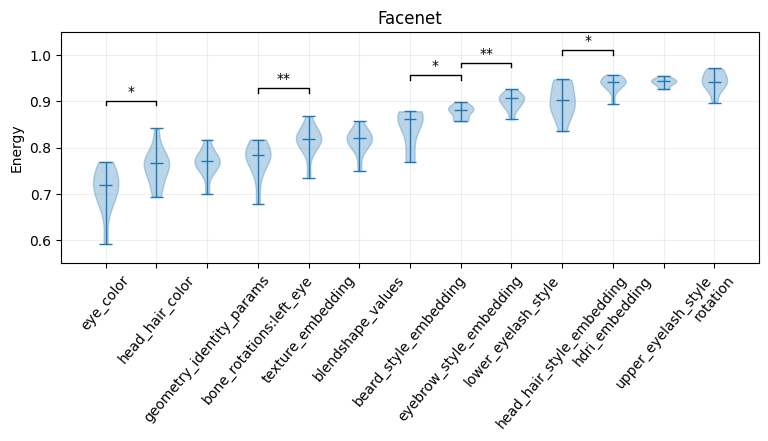

In [28]:
agg_energy = np.array(np.array([[np.mean(e) for e in i] for i in results_dict["energy"]["retina_facenet"]]))
perm = np.argsort(np.mean(agg_energy,0))


features = metadata["feature"].unique()[perm]
f = plt.figure(figsize=(9,3))
vlpt = plt.violinplot(agg_energy[:,perm], showmedians = True);
for pc in vlpt['bodies']:
    pc.set_facecolor('tab:blue')
    pc.set_edgecolor('tab:blue')
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vlpt[partname]
    vp.set_edgecolor("tab:blue")
    vp.set_linewidth(1)
plt.xticks(ticks=range(1,len(features)+1),labels = features, rotation = 50);
plt.ylabel("Energy")
#plt.hlines(1,0.5,len(features)+.5,color = "black", label = "Random")
plt.title("Facenet")
plt.grid(alpha = 0.2)
#plt.legend(loc = "lower right")
plt.ylim([0.55,1.05])

significant_combinations = []
# Check from the outside pairs of boxes inwards
combinations = [(i+1,i+2) for i in range(12)]
#combinations = list(itertools.combinations(range(1,13),2))
energy2 = agg_energy[:,perm]

for combination in combinations:
    data1 = energy2[:,combination[0] - 1]
    data2 = energy2[:,combination[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([combination, p])

bottom, top = 0.55,1.05

plt.ylim([bottom,top])

y_range = top - bottom

for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = 0.5*len(significant_combinations) - (5-i)
    # Plot the bar
    bar_height = (y_range * 0.055 * level) + top-0.08
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = "ns"
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

#plt.savefig("facenet_cos.pdf",bbox_inches='tight')
#plt.hlines(0,0.5,5.5,color = "gray")

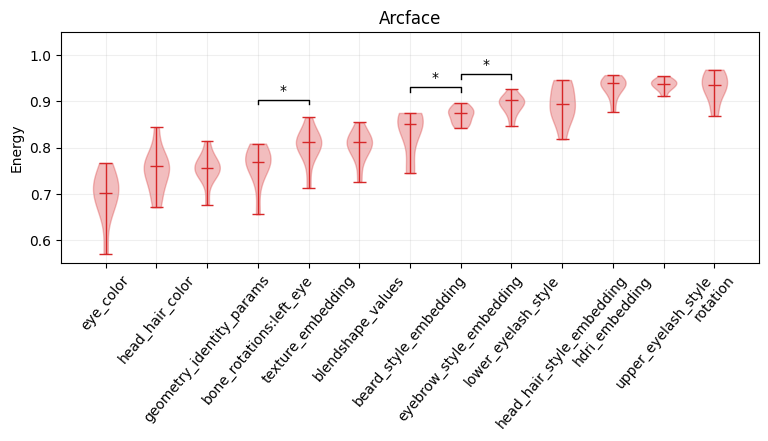

In [29]:
agg_energy2 = np.array(np.array([[np.mean(e) for e in i] for i in results_dict["energy"]["retina_arcface"]]))
perm = np.argsort(np.mean(agg_energy,0))


features = metadata["feature"].unique()[perm]
f = plt.figure(figsize=(9,3))
vlpt = plt.violinplot(agg_energy2[:,perm], showmedians = True);
for pc in vlpt['bodies']:
    pc.set_facecolor('tab:red')
    pc.set_edgecolor('tab:red')
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vlpt[partname]
    vp.set_edgecolor("tab:red")
    vp.set_linewidth(1)
plt.xticks(ticks=range(1,len(features)+1),labels = features, rotation = 50);
plt.ylabel("Energy")
#plt.hlines(1,0.5,len(features)+.5,color = "black", label = "Random")
plt.title("Arcface")
plt.grid(alpha = 0.2)
#plt.legend(loc = "lower right")
plt.ylim([0.55,1.05])

significant_combinations = []
# Check from the outside pairs of boxes inwards
combinations = [(i+1,i+2) for i in range(12)]
energy2 = agg_energy2[:,perm]

for combination in combinations:
    data1 = energy2[:,combination[0] - 1]
    data2 = energy2[:,combination[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([combination, p])

bottom, top = 0.55,1.05

plt.ylim([bottom,top])

y_range = top - bottom

for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = 0.5*len(significant_combinations) - (5-i)
    # Plot the bar
    bar_height = (y_range * 0.055 * level) + top-0.05
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

plt.savefig("arcface_cos.pdf",bbox_inches='tight')
#plt.hlines(0,0.5,5.5,color = "gray")